In [65]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import GCCA, shuffle_block, data_superbowl, corr_component, avg_corr_coe
from sklearn.covariance import LedoitWolf
from numpy import linalg as LA
from scipy import signal
from tqdm import tqdm

In [66]:
# data = scipy.io.loadmat('../Correlated Component Analysis/data/Prepro_EEG.mat')
# X_prepro = data['X']
# fs = 256
# T, D, N = X_prepro.shape

In [67]:
head = '../Correlated Component Analysis/data'
datatype = 'preprocessed'
year = '2013'
view = 'Y2'
X_prepro, fs = data_superbowl(head=head, datatype=datatype, year=year, view=view)
T, D, N = X_prepro.shape

In [68]:
n_components = 100
lam, W_stack, avg_corr = GCCA(X_prepro, n_components=n_components, regularization='lwcov')
avg_corr

array([0.18005508, 0.0991119 , 0.08692264, 0.08293346, 0.08498307,
       0.08271434, 0.08249398, 0.0816447 , 0.07850436, 0.07850623,
       0.07764838, 0.07497025, 0.07421793, 0.07253902, 0.07251337,
       0.07299535, 0.0718717 , 0.07048556, 0.07049304, 0.06979781,
       0.0690646 , 0.06796717, 0.06791562, 0.06603929, 0.06617355,
       0.06492945, 0.0655243 , 0.06434227, 0.06385139, 0.06336423,
       0.06197271, 0.06269373, 0.06225381, 0.0608914 , 0.060152  ,
       0.06020744, 0.05985386, 0.05932749, 0.05924087, 0.05855758,
       0.05754694, 0.05785935, 0.05632178, 0.05628798, 0.05638415,
       0.05502164, 0.05509279, 0.05511369, 0.05502377, 0.05400012,
       0.054019  , 0.0536099 , 0.05217731, 0.05258046, 0.05125271,
       0.05142826, 0.05083795, 0.05109541, 0.05075113, 0.05007191,
       0.04915437, 0.04882485, 0.04877187, 0.04852315, 0.04766367,
       0.04799059, 0.04779871, 0.04709076, 0.04660186, 0.04642969,
       0.04638822, 0.04568219, 0.0458094 , 0.04510398, 0.04533

In [69]:
avg_corr_coe(X_prepro, W_stack, N, n_components=n_components)

array([0.18064173, 0.09982907, 0.08778709, 0.08382344, 0.08573119,
       0.08343065, 0.08329149, 0.08241773, 0.07924975, 0.07931434,
       0.07843813, 0.07567953, 0.07498076, 0.07331521, 0.07333284,
       0.07376023, 0.07266424, 0.07126384, 0.07128252, 0.0706323 ,
       0.06983774, 0.06867401, 0.06862453, 0.06663173, 0.06699177,
       0.06561624, 0.06615254, 0.06498249, 0.06457283, 0.06403169,
       0.06267496, 0.06339668, 0.06291907, 0.06160056, 0.06079176,
       0.06082487, 0.06049826, 0.06001476, 0.05990987, 0.05925334,
       0.05821963, 0.05854204, 0.05695906, 0.05689197, 0.05697711,
       0.05562792, 0.05568028, 0.05568141, 0.05564446, 0.05459139,
       0.05458678, 0.05418752, 0.05275846, 0.05322699, 0.05182177,
       0.05204979, 0.05145284, 0.0516734 , 0.05137191, 0.05062658,
       0.04973821, 0.04935777, 0.04937288, 0.04908707, 0.04828398,
       0.04855497, 0.04828947, 0.04761988, 0.04714374, 0.04698639,
       0.04690857, 0.04617143, 0.04627111, 0.04564215, 0.04580

In [70]:
(1/lam-1)/(N-1)

array([0.18236032, 0.10144515, 0.08967117, 0.08887496, 0.08700949,
       0.08487248, 0.08419637, 0.08319207, 0.08042315, 0.07973125,
       0.07885866, 0.07708085, 0.07598439, 0.07505532, 0.0746798 ,
       0.07444365, 0.07354037, 0.07290871, 0.07181507, 0.07094741,
       0.07060448, 0.0695647 , 0.06903632, 0.06880191, 0.06767806,
       0.06676661, 0.06641381, 0.06591469, 0.06544451, 0.06434192,
       0.06377804, 0.06351424, 0.06319411, 0.06199038, 0.06186694,
       0.06160735, 0.06127702, 0.06056091, 0.06003697, 0.05963927,
       0.05913023, 0.05903283, 0.05804221, 0.05774855, 0.05727804,
       0.05653588, 0.05611413, 0.05582152, 0.05542439, 0.05515754,
       0.05482781, 0.0546188 , 0.05340483, 0.05313662, 0.05254492,
       0.05220728, 0.05196731, 0.05180366, 0.05123209, 0.05116682,
       0.05023084, 0.04965943, 0.04943792, 0.04935515, 0.04893035,
       0.04862408, 0.0481811 , 0.04767172, 0.04736318, 0.04706782,
       0.04676833, 0.04636913, 0.04629925, 0.04595701, 0.04575

Difference between avg_corr and the one computed by function `avg_corr_coe` is due to the regularization when computing covariance matrices.

(1/lam-1)/(N-1) is an approximation of real average pairwise correlation. It assumes that $\mathbf w_n^H \mathbf R_{\mathbf x_n \mathbf x_n} \mathbf w_n$ is equal for all $n$ (different subject), which is not true. In all cases we have here, this approximation is actually good enough.

In [71]:
# Reference value
X_single_channel = X_prepro[:,10,:]
corr_mtx = np.corrcoef(X_single_channel, rowvar=False)
np.sum(corr_mtx-np.eye(N))/N/(N-1)

0.03969196883482774

### Permutation Test

In [40]:
num_test = 100
corr_topK = np.empty((0, n_components))
for i in tqdm(range(num_test)):
    X_shuffled = shuffle_block(X_prepro, t=3, fs=fs)
    _, _, corr_permu = GCCA(X_shuffled, n_components=n_components, regularization='lwcov')
    # _, _, corr_permu = GCCA(X_shuffled, n_components=n_components, regularization='lwcov', W_train=W_stack)
    corr_topK = np.concatenate((corr_topK, np.expand_dims(corr_permu, axis=0)), axis=0)

100%|██████████| 100/100 [05:29<00:00,  3.29s/it]


Component 1, top 0.0%


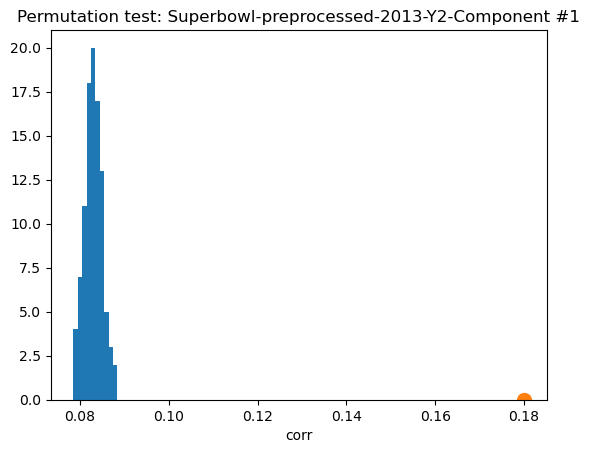

In [41]:
compo = 1
signifi = sum(corr_topK[:,0]>avg_corr[compo-1])/num_test*100
print("Component {compo}, top {signifi}%".format(compo=compo, signifi=signifi))
plt.hist(corr_topK[:,0])
# plt.title('Permutation test: Example-'+'Component #'+str(compo))
plt.title('Permutation test: Superbowl-'+datatype+'-'+year+'-'+view+'-'+'Component #'+str(compo))
plt.xlabel('corr')
plt.plot(avg_corr[compo-1], 0, marker="o", markersize=10)

### Cross-validation

In [10]:
fold = 10
cv_n_components = 5
corr_train = np.zeros((fold, cv_n_components))
corr_test = np.zeros_like(corr_train)
T, D, N = X_prepro.shape
for i in range(fold):
    len_test = T // fold
    X_test = X_prepro[len_test*i:len_test*(i+1),:,:]
    X_train = np.delete(X_prepro, range(len_test*i, len_test*(i+1)), axis=0)
    _, W_train, corr_train[i,:] = GCCA(X_train, n_components=n_components, regularization='lwcov')
    # corr_train[i,:] = avg_corr_coe(X_train, W_train, N, n_components=cv_n_components)
    _, _, corr_test[i,:] = GCCA(X_test, n_components=n_components, regularization='lwcov', W_train=W_train)

In [11]:
np.mean(corr_train, axis=0)

array([0.1828905 , 0.1031513 , 0.09170862, 0.09049872, 0.08981684])

In [12]:
np.mean(corr_test, axis=0)

array([ 0.11516844,  0.02993057, -0.00094616,  0.00425634,  0.00174643])

### GCCA vs Correlated Component Analysis

In [13]:
fold = 10
cv_n_components = 5
ISC_train = np.zeros((fold, cv_n_components))
ISC_test = np.zeros_like(ISC_train)
T, D, N = X_prepro.shape
for i in range(fold):
    len_test = T // fold
    X_test = X_prepro[len_test*i:len_test*(i+1),:,:]
    X_train = np.delete(X_prepro, range(len_test*i, len_test*(i+1)), axis=0)
    ISC_train[i,:], W_train = corr_component(X_train, n_components=n_components)
    ISC_test[i,:], _ = corr_component(X_test, n_components=n_components, W_train=W_train)

In [14]:
np.mean(ISC_train, axis=0)

array([0.11514458, 0.04036184, 0.02881643, 0.02289647, 0.02139846])

In [15]:
np.mean(ISC_test, axis=0)

array([ 0.10402141,  0.02557607,  0.01402412,  0.00371617, -0.00083705])